<a href="https://colab.research.google.com/github/AnandVishnuG/ImageCaptioningLSTM/blob/main/ImageCaptioningLSTMPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
from google.colab import files, drive
from tqdm import tqdm 
from PIL import Image
from pickle import dump, load
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Reshape
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from keras.preprocessing.image import ImageDataGenerator

import itertools
import numpy as np
import pandas as pd
import os


In [4]:
# Mount Google drive for accessing files
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Create a dictionary of images as keys and each image's descriptions as items
def data_to_dictionary(data):
    descriptions = {}
    for idx, row in data.iterrows():
        if row["image"] not in descriptions:
            descriptions.setdefault(row["image"], []).append(row["caption"])
        else:
            descriptions[row["image"]].append(row["caption"])
    return descriptions
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc    
# Converting captions to tokens
def list_to_tokens(desc_list):
  tokens = []
  for desc in desc_list:
    tokens.append(word_tokenize(desc))
  return tokens


In [5]:
# Read Captions file 
captions = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/captions_clean.txt",encoding="cp1252")
# Create descriptions dictionary containing image keys and corresponding captions
descriptions = data_to_dictionary(captions)


1/1 [==============================] - 1s 1s/step



Prediction_rotation: A man riding a bike on a dirt track.
Prediction_shift: A man is riding a bike.
Prediction_color: A man is riding a dirt bike down a dirt trail.
Prediction_brightness: A man riding a bike on a dirt track.

BLEU_rotation: 0.7311104457090247
BLEU_shift: 0.5259768954407417
BLEU_color: 0.7264258597258696
BLEU_brightness: 0.7311104457090247


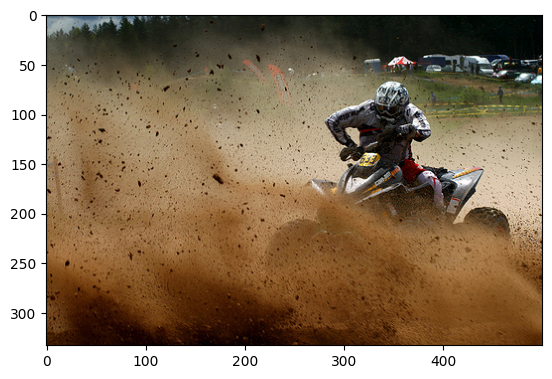

1/1 [==============================] - 1s 717ms/step



Prediction_rotation: A man in a red shirt is jumping off a rock.
Prediction_shift: A man in a red shirt is jumping off a ramp.
Prediction_color: A man in a red shirt is jumping over a bike.
Prediction_brightness: A man in a red shirt is riding a bike on a bike.

BLEU_rotation: 0.6341971736391129
BLEU_shift: 0.6341971736391129
BLEU_color: 0.7770796579977366
BLEU_brightness: 0.5590235987560461


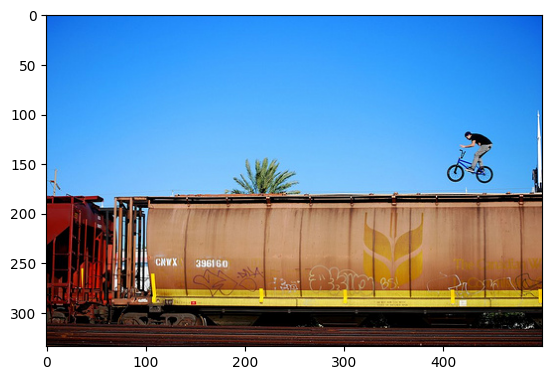

1/1 [==============================] - 1s 712ms/step



Prediction_rotation: A man in a blue shirt is jumping into a pool.
Prediction_shift: A man in a blue shirt is jumping in the air.
Prediction_color: A man in a blue shirt is jumping into a pool.
Prediction_brightness: A man in a blue wetsuit is riding a wave.

BLEU_rotation: 0.34139700231435577
BLEU_shift: 0.40860344372745616
BLEU_color: 0.34139700231435577
BLEU_brightness: 0.40599182013877255


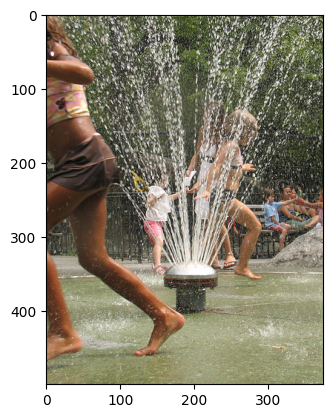

1/1 [==============================] - 0s 393ms/step



Prediction_rotation: A man in a black shirt and a black shirt and a black shirt is standing on a bench.
Prediction_shift: A man in a black shirt and black shirt is standing in front of a bench.
Prediction_color: A man in a red shirt is sitting on a street.
Prediction_brightness: A man in a red shirt and a black shirt is sitting on a red and white building.

BLEU_rotation: 0.3951795763453034
BLEU_shift: 0.519305284952541
BLEU_color: 0.3975341837700886
BLEU_brightness: 0.4719419216032584


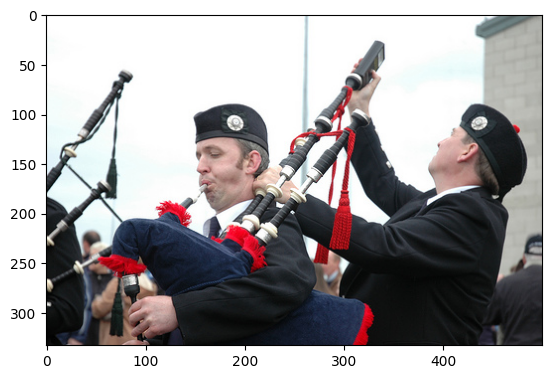

1/1 [==============================] - 0s 398ms/step



Prediction_rotation: A man in a red shirt is jumping over a red horse.
Prediction_shift: A dog is running through the grass.
Prediction_color: A dog is running through a field.
Prediction_brightness: A dog is running through the snow.

BLEU_rotation: 0.29510826722155437
BLEU_shift: 0.37449490537973773
BLEU_color: 0.3034791322400559
BLEU_brightness: 0.4122519210279467


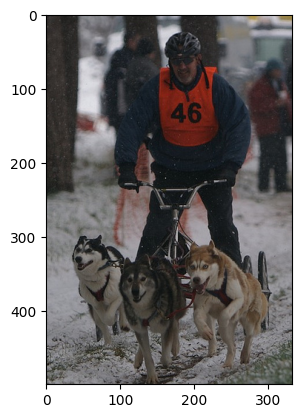

In [7]:
from pandas import read_csv
import random
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score

from tensorflow.keras.applications import Xception

def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature

smooth_func = SmoothingFunction().method1

file = open('/content/drive/MyDrive/Colab Notebooks/data/Flickr_8k.testImages.txt',"r")
test_images = []
prediction_rotation = load(open("/content/drive/MyDrive/Colab Notebooks/data/Prediction_dataAugx2/predictions_aug2_rotation.p","rb"))
# feature_rotation = load(open("/content/features_aug2_rotation.p","rb"))
prediction_shift = load(open("/content/drive/MyDrive/Colab Notebooks/data/Prediction_dataAugx2/predictions_aug2_shift.p","rb"))
# feature_shift
prediction_color = load(open("/content/drive/MyDrive/Colab Notebooks/data/Prediction_dataAugx2/predictions_aug2_color (1).p","rb"))
# feature_color = load(open("/content/features_aug2_color.p","rb"))
prediction_brightness = load(open("/content/drive/MyDrive/Colab Notebooks/data/Prediction_dataAugx2/predictions_aug2_brightness.p","rb"))
# feature_brightness = load(open("/content/features_aug2_brightness.p","rb"))
for filename in file.read().split("\n")[:-1]:
    test_images.append(filename)
# model = load_model("models\\model2_19.h5")
xception_model = Xception(include_top=False, pooling="avg")
for i in range(0,5):
    rand_idx = random.randint(0, len(test_images)-1)
    fname = "/content/drive/MyDrive/Colab Notebooks/data/Images/" + test_images[rand_idx]
    photo_rotation = extract_features (fname, xception_model)
    img = Image.open(fname)
    disc_rotation = prediction_rotation[rand_idx]
    disc_shift = prediction_shift[rand_idx]
    disc_color = prediction_color[rand_idx]
    disc_brightness = prediction_brightness[rand_idx]
    print("\n\n")
    # Prediction
    print("Prediction_rotation: {}".format(disc_rotation))
    print("Prediction_shift: {}".format(disc_shift))
    print("Prediction_color: {}".format(disc_color))
    print("Prediction_brightness: {}".format(disc_brightness))
    print()
    # Description
    score_rotation = sentence_bleu(descriptions[test_images[rand_idx]], disc_rotation, smoothing_function=smooth_func)
    score_shift = sentence_bleu(descriptions[test_images[rand_idx]], disc_shift, smoothing_function=smooth_func)
    score_color = sentence_bleu(descriptions[test_images[rand_idx]], disc_color, smoothing_function=smooth_func)
    score_brightness = sentence_bleu(descriptions[test_images[rand_idx]], disc_brightness, smoothing_function=smooth_func)
    
    print("BLEU_rotation: {}".format(score_rotation))  
    print("BLEU_shift: {}".format(score_shift))  
    print("BLEU_color: {}".format(score_color))  
    print("BLEU_brightness: {}".format(score_brightness))  
    plt.figure()
    plt.imshow(img)
    plt.show(block=True)